# imports

In [ ]:
import sys
sys.path.append("C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package")
from data_preparation import DataPreparation, Analysis, multi_data_ops
import data_operations as do

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import math
import matplotlib.gridspec as gridspec

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

import joblib

## Models

In [199]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, KFold
from scipy.stats import loguniform

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight



## Scoring

In [200]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

### Functions

In [201]:
#grouping lead_provider_name into less granular categories
def lead_prov_grouping(prov):
    if prov in ['Recycled Freemium', 'SPL-Freemium', 'Sold Freemium','Quoted Freemium', 'ABBY Freemium', 'Freemium','CellC-Freemium']:
        return 'Freemium'
    elif prov in ['LeadWarming', 'LeadWarming TN ', 'Lead Warming']:
        return 'LeadWarming'
    elif prov in ['BLDS 101', 'BLDS']:
        return 'BLDS'
    elif prov in ['SD Phone Leads','MWL Phone Leads', 'iTalk External Call Center']:
        return 'Phone leads'
    elif prov in ['Sanlam Direct Cape Referral', 'SDC-Referral', 'MWL Referrals']:
        return 'Refferals'
    elif prov in ['Website',  'Bing', 'SD Web','MWL Web', 'Sanlam Digital','GoogleDisplay','GoogleSearch']:
        return 'Web'
    elif prov in ['MiWayLife', 'Sure_Strat_MWL','Existing Client','Reach_Republic_MWL', 'Newsletter']:
        return 'MWL'
    elif prov in ['Lead-D365-Production', 'Sanlam-Lead-D365-Production']:
        return 'D365'
    elif prov in ['Recycled','Facebook', 'Reinstatement', 'Vicidial','Wills', 'Affiliate', 'Sanlam Direct Cape', 'LiveLeads','SEO',
       'Competitions', 'SDC HIV','Olico']:
        return 'Other'
    else:
        return 'Other'


In [202]:
def data_prep(data,target,features=[],filter=None,column_excl = ['3month_lapse', '6month_lapse', 'ann_lapse', 'lapse_flag', 'policy_name'],cat_cols=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_provider_groups', 'lead_type', 'sales_channel','hiv_group', 'securitygroup_id', 'age_band',
       'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium_band','underwriting_outcome'],imp_dict={'optionality': 'mode','cover_amount_full':'mean'}):

    if filter is not None:
        data = data[data[filter].notnull()].copy() 
                #for annual lapse, only policies older than 11 months have a flag, 
                        #thus excluding missing values for anniversary lapse flag excludes the policies younger than 11 months

    #imputing nulls
    df=DataPreparation(df=data)
    df.imputating_nulls(imp_dict=imp_dict)
    data=df.imputed_df.copy()

    #grouping lead-provider_name
    data['lead_provider_groups']= data['lead_provider_name'].apply(lead_prov_grouping)
    data.drop(columns=['lead_provider_name'],inplace=True)
    cat_cols.append('lead_provider_groups')

    #hot-one encoding categorical features
    data=pd.get_dummies(data,columns=cat_cols, dtype=int)
    if features == []:
        cols=set(data.columns)
        features=list(cols.difference(column_excl))

    #split data and target     
    X = data[features].copy()
    Y = data[target].astype(int).copy()
    
    # Train Test Split
    X_train, X_test, Y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42, stratify=Y)

    return X_train, X_test, Y_train, y_test


In [203]:
#custom score for models
from sklearn.metrics import make_scorer
def my_custom_accuracy(y_true, y_pred):
    w=2
    cm = confusion_matrix(y_true, y_pred)
    true_0 =(cm[0][0]/(cm[0][0]+cm[0][1]))
    true_1= w*(cm[1][1]/(cm[1][1]+cm[1][0]))

    return (true_0+true_1)/(1+w)
custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)

## Plot functions

In [204]:
#functions for plotting continous features
def plot_histogram_boxplot_kde(data, title="Data Distribution", x_label="Value"):
    """
    Generates a combined plot showing a histogram with KDE, a box plot,
    and summary statistics.

    Args:
        data (array-like): A list, numpy array, or pandas Series of numerical data.
        title (str, optional): The main title for the plot. Defaults to "Data Distribution".
        x_label (str, optional): The label for the x-axis. Defaults to "Value".
    """
    # Convert data to a pandas Series to easily handle potential NaNs and calculations
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    # Drop NaN values to avoid errors in plotting and calculations
    print('Number of NaN values to be dropped: ',data.isnull().sum())
    data = data.dropna()

    if data.empty:
        print("Warning: Input data is empty or contains only NaN values. Cannot generate plot.")
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics for display
    stats_text = (
        f"Statistics:\n"
        f"-----------\n"
        f"Count: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Std Dev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Set up the plot layout ---
    # Create a figure
    fig = plt.figure(figsize=(10, 6))
    # Define the grid layout: 2 rows, 2 columns.
    # Top row for box plot, bottom row for histogram.
    # Right column for text.
    # Adjust width/height ratios for better spacing.
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4],
                           figure=fig, wspace=0.1, hspace=0.05) # Reduced space

    # Create axes for each part of the plot
    ax_hist = fig.add_subplot(gs[1, 0])        # Histogram/KDE at bottom-left
    ax_box = fig.add_subplot(gs[0, 0], sharex=ax_hist) # Box plot at top-left, sharing x-axis
    ax_text = fig.add_subplot(gs[:, 1])        # Text box spanning both rows on the right

    # --- Plot the data ---
    # 1. Histogram and KDE plot (using seaborn for convenience)
    #    'bins="auto"' lets seaborn/numpy choose a suitable number of bins.
    #    'kde=True' adds the Kernel Density Estimate.
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label)
    ax_hist.set_ylabel("Density")

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1.5, label=f'Median ({median_val:.2f})')
    ax_hist.legend(loc='upper right') # Add legend to histogram plot

    # 2. Box plot
    #    Use seaborn's boxplot for consistency.
    #    'orient='h'' makes it horizontal.
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('') # Remove x-label as it's shared with histogram
    # Remove y-ticks and labels from boxplot for cleaner look
    ax_box.set_yticks([])
    ax_box.set_ylabel('') # Remove y-label

    # Remove ticks and labels from the top x-axis of the box plot
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False) # Remove ticks

    # 3. Statistics Text Box
    ax_text.axis('off') # Turn off the axis lines and ticks
    # Place the text in the center of the text axes
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=10, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.5))

    # --- Final Touches ---
    fig.suptitle(title, fontsize=16) # Add overall title
    # Adjust layout to prevent labels/titles overlapping
    # plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
    fig.subplots_adjust(top=0.92) # Adjust top margin for suptitle

#--------------------------------------------------------------------------------------------------------------------------------------------

# --- Helper function to plot distribution for a single category ---
# This adapts the logic from the previous function to draw on specific axes
def _plot_single_distribution(data, fig, ax,title="Distribution", x_label="Value"):
    """
    Helper function to draw histogram, KDE, box plot, and stats on a given Axes object
    by creating a nested GridSpec.

    Args:
        data (pd.Series): Numerical data for a single category (NaNs already handled).
        fig (matplotlib.figure.Figure): The main figure object.
        ax (matplotlib.axes.Axes): The main Axes object (from the outer grid)
                                   to draw this category's plot within.
        title (str): Title for this specific subplot.
        x_label (str): Label for the x-axis.
    """

    
  
    # Get the SubplotSpec from the parent Axes object
    ss = ax.get_subplotspec()
    # Turn off the axis frame/ticks for the original 'ax' as its space will be managed by the nested GridSpec
    ax.axis('off')

    if data.empty:
        # If data is empty, add text to the original Axes location
        ax.text(0.5, 0.5, "No data for this category",
                horizontalalignment='center', verticalalignment='center',
                transform=ax.transAxes, fontsize=10, color='grey')
        ax.set_title(title, fontsize=10) # Set title on the original Axes
        return

    # --- Calculate Statistics ---
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)

    # Format statistics
    stats_text = (
        f"N: {count}\n"
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"StdDev: {std_dev:.2f}\n"
        f"Q1: {q1:.2f}\n"
        f"Q3: {q3:.2f}\n"
        f"IQR: {iqr:.2f}"
    )

    # --- Create inset axes within the main 'ax' space using its SubplotSpec ---
    gs_inset = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=ss, # Use the SubplotSpec here
                                                width_ratios=[4, 1], height_ratios=[1, 4],
                                                wspace=0.05, hspace=0.05)

    # Create the actual Axes using the main figure and the nested GridSpec indices
    ax_hist = fig.add_subplot(gs_inset[1, 0]) # Histogram at bottom-left
    ax_box = fig.add_subplot(gs_inset[0, 0], sharex=ax_hist) # Box plot at top-left
    ax_text = fig.add_subplot(gs_inset[:, 1]) # Text box on the right

    # --- Plot the data ---
    # 1. Histogram and KDE
    sns.histplot(data, bins="auto", kde=True, ax=ax_hist, stat='density')
    ax_hist.set_xlabel(x_label, fontsize=9) # Slightly smaller font for subplot labels
    ax_hist.set_ylabel("Density", fontsize=9)
    ax_hist.tick_params(axis='both', which='major', labelsize=8) # Smaller tick labels

    # Add vertical lines for mean and median
    ax_hist.axvline(mean_val, color='red', linestyle='--', linewidth=1, label=f'Mean ({mean_val:.2f})')
    ax_hist.axvline(median_val, color='green', linestyle=':', linewidth=1, label=f'Median ({median_val:.2f})')
    ax_hist.legend(fontsize='x-small', loc='upper right') # Smaller legend

    # 2. Box plot
    sns.boxplot(x=data, ax=ax_box, orient='h', color='lightblue')
    ax_box.set_xlabel('')
    ax_box.set_yticks([])
    ax_box.set_ylabel('')
    plt.setp(ax_box.get_xticklabels(), visible=False)
    ax_box.tick_params(axis='x', which='both', bottom=False)

    # 3. Statistics Text Box
    ax_text.axis('off')
    ax_text.text(0.05, 0.5, stats_text, transform=ax_text.transAxes,
                 fontsize=8, verticalalignment='center',
                 bbox=dict(boxstyle='round,pad=0.3', fc='aliceblue', alpha=0.5))

    # Set the title for the specific subplot (category) on the original Axes container
    ax.set_title(title, fontsize=10)

#--------------------------------------------------------------------------------------------------------------------------------------------------

# --- Main function to create the grid plot ---
def plot_grouped_distributions(df, value_col, category_col='none',cat_list = [], main_title="Grouped Distributions"):
    """
    Generates a grid of distribution plots (hist, KDE, boxplot, stats)
    for numerical data grouped by a categorical column.

    Args:
        df (pd.DataFrame): The input DataFrame.
        value_col (str): The name of the column with numerical data.
        category_col (str): The name of the column with categorical data.
        main_title (str, optional): The main title for the entire figure.
                                    Defaults to "Grouped Distributions".
    """

    if category_col == 'none':
        
        plot_histogram_boxplot_kde(df[value_col], title=f"Distribution of {value_col}", x_label=value_col)

    else:

        # Check if columns exist
        if value_col not in df.columns:
            print(f"Error: Value column '{value_col}' not found in DataFrame.")
            return
        if category_col not in df.columns:
            print(f"Error: Category column '{category_col}' not found in DataFrame.")
            return

        if len(cat_list) != 0:
            df = df[df[category_col].isin(cat_list)].copy()

        # Get unique categories and handle potential NaNs in category column
        # Sort categories for consistent plot order
        categories = sorted(df[category_col].dropna().unique())
        n_categories = len(categories)

        if n_categories == 0:
            print(f"Warning: No valid categories found in column '{category_col}'. Cannot generate plot.")
            return

        # --- Determine grid layout ---
        # Aim for a layout that's roughly square
        ncols = math.ceil(math.sqrt(n_categories))
        nrows = math.ceil(n_categories / ncols)

        # --- Create figure and subplots ---
        # Adjust figsize based on grid size for better readability
        # Increased base size slightly for better spacing within subplots
        fig_width = ncols * 5.5
        fig_height = nrows * 4.5
        fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height), squeeze=False)

        # Flatten axes array for easy iteration
        axes_flat = axes.flatten()

        # --- Plot data for each category ---
        for i, category in enumerate(categories):
            ax = axes_flat[i]
            # Filter data for the current category, dropping NaNs in the value column
            category_data = df[df[category_col] == category][value_col].dropna()

            # Call the helper function to plot on the current axes
            # Pass the main 'fig' object as well
            _plot_single_distribution(category_data, fig, ax, # Pass fig and ax
                                      title=f"{category}", # Simpler title, category name only
                                      x_label=value_col)

        # --- Clean up unused subplots ---
        for i in range(n_categories, len(axes_flat)):
            axes_flat[i].axis('off') # Hide unused axes

        # --- Final Touches ---
        # Add a more descriptive main title including column names
        full_main_title = f"{main_title}: {value_col} by {category_col}"
        fig.suptitle(full_main_title, fontsize=16, y=1.0) # Adjust title position slightly
        # Use tight_layout first, then adjust spacing if needed
        plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust rect to prevent overlap and make space for title/labels
        # plt.subplots_adjust(top=0.92, hspace=0.4, wspace=0.3) # Fine-tune spacing if tight_layout isn't enough

    plt.show()

In [205]:
#bar comparison
def bar_comp(df,category, split):
    
    props=df.groupby(split)[category].value_counts(normalize=True).rename('proportion').reset_index()

    plt.figure(figsize=(10,6))
    sns.barplot(
        data=props,
        x=category,
        y='proportion',
        hue=split,
        palette='viridis')  
    
    # Set the title and labels for clarity.
    plt.title(f'Proportion of {category} by {split}', fontsize=16)
    plt.xlabel(category, fontsize=12)
    plt.ylabel('Proportion', fontsize=12)
    plt.xticks(rotation=45) # Rotate x-axis labels for better readability
    plt.legend(title=split)

    # Add annotations to the bars to show the exact proportion.
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}',
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center',
                           fontsize=10, color='black',
                           xytext=(0, 5),
                           textcoords='offset points')

    plt.tight_layout() # Adjust layout to make room for the labels.
    plt.show()





# Training Data

In [211]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/AtInception/"
data=pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))
data=data.drop(columns=['Unnamed: 0','occupation','campaign_name','hiv_group'])
data_info=DataPreparation(df=data)
display(data_info.null_df)

,nulls,percentage nulls
policy_name,0,0.000000
age,0,0.000000
education,0,0.000000
gender,0,0.000000
income,0,0.000000
smoker_status,0,0.000000
sold_socio_economic_class,0,0.000000
occupation_class,0,0.000000
lead_provider_name,0,0.000000
lead_type,0,0.000000


In [212]:
#scaling numerical, countinous features

scale = StandardScaler()
data_s=data.copy()
column_scale=[ 'age',  'income',  'eml','pml',  'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum','inflation', 'unemployment rate']
data_s[column_scale] = scale.fit_transform(data_s[column_scale])

 #columns to be hot-one encoded
categorical_cols=['education', 'gender', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class',
       'lead_type', 'optionality', 'hiv_test_required', 'age_band',
        'original_premium_band']

 #columns with nulls to be imputed and the method of imputation
impt_dict={'optionality': 'mode','cover_amount_full':'mean'}

#dropping unimportant features
data_s.drop(columns=['underwriting_outcome','securitygroup_id','sales_channel',
 'age', 'income_band', 'last_benefit_amount_band', 'cover_amount_full_band',
       'total_funeral_premium_band', 'original_premium'],inplace=True)





# Lapses within 3 Months

XGBoost classification model with SMOTE resampling

## Training

In [213]:
target='3month_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())




#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)


#apply SMOTE resampling
sm = SMOTE(sampling_strategy=0.4,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())
print('smote resampling target ratio: ',Y_smote.sum()*100/Y_smote.count())

target ratios:  19.873746418338108
smote resampling target ratio:  28.568577558249764


In [214]:


# Create a mask for the rows where inflation is 3
inflation_mask_3 = X_train['inflation'] == 3

# Apply the same mask to filter the training and test sets
X_train_2025 = X_train[inflation_mask_3].copy()
Y_train_2025 = Y_train[inflation_mask_3].copy()

# The same logic applies to the test sets
inflation_mask_3_test = x_test['inflation'] == 3

x_test_2025 = x_test[inflation_mask_3_test].copy()
y_test_2025 = y_test[inflation_mask_3_test].copy()


# Create a mask for the rows where inflation is not 3
inflation_mask_not_3 = X_train['inflation'] != 3

# Apply the mask to the training and SMOTE sets
X_train = X_train[inflation_mask_not_3]
Y_train = Y_train[inflation_mask_not_3]

inflation_mask_not_3_test = x_test['inflation'] != 3

x_test = x_test[inflation_mask_not_3_test]
y_test = y_test[inflation_mask_not_3_test]

smote_inflation_mask_not_3 = X_smote['inflation'] != 3

X_smote = X_smote[smote_inflation_mask_not_3]
Y_smote = Y_smote[smote_inflation_mask_not_3]

In [ ]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()
scorer=custom_scorer

#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


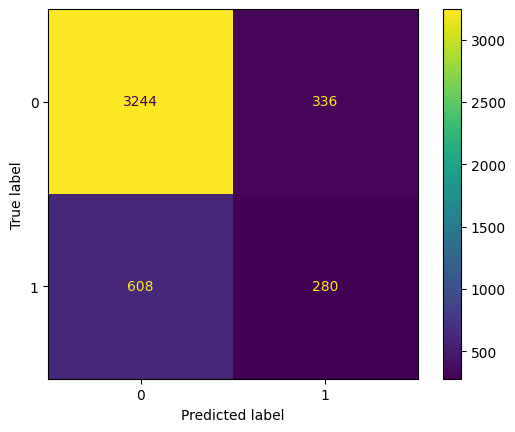

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [ ]:
joblib.dump(xgbc, '3month_lapse_model.joblib')

['3month_lapse_model.joblib']

## Model for scoring

In [ ]:
new_data = X_train_2025.copy()#x_test.copy()
pol_names = pd.DataFrame({'index':data_s.index,'policy_name':data_s['policy_name']})
new_data['index']=new_data.index
new_data = pd.merge(new_data,pol_names,on='index',how='left')
new_data.drop(columns=['index'],inplace=True)
model_file='3month_lapse_model.joblib'
m3_model = joblib.load(model_file)
score_data = new_data.loc[:, list(m3_model.feature_names_in_)].copy()
m3_prediction = m3_model.predict(score_data)
m3_prob = m3_model.predict_proba(score_data)

# Lapses within 6 months

XGBoost classifier

## Training

In [ ]:
target='6month_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())




#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)



target ratios:  27.44448424068768


In [ ]:
# Create a mask for the rows where inflation is not 3
inflation_mask_not_3 = X_train['inflation'] != 3

# Apply the mask to the training and SMOTE sets
X_train = X_train[inflation_mask_not_3]
Y_train = Y_train[inflation_mask_not_3]

inflation_mask_not_3_test = x_test['inflation'] != 3

x_test = x_test[inflation_mask_not_3_test]
y_test = y_test[inflation_mask_not_3_test]

smote_inflation_mask_not_3 = X_smote['inflation'] != 3

X_smote = X_smote[smote_inflation_mask_not_3]
Y_smote = Y_smote[smote_inflation_mask_not_3]

In [ ]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


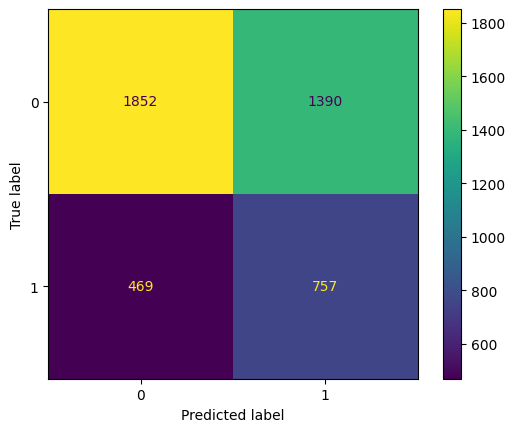

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [ ]:
joblib.dump(xgbc, '6month_lapse_model.joblib')

['6month_lapse_model.joblib']

## Model for scoring

In [ ]:

#new_data = x_test.copy()
#pol_names = pd.DataFrame({'index':data_s.index,'policy_name':data_s['policy_name']})
#new_data['index']=new_data.index
#new_data = pd.merge(new_data,pol_names,on='index',how='left')
#new_data.drop(columns=['index'],inplace=True)
model_file='6month_lapse_model.joblib'
m6_model = joblib.load(model_file)
score_data = new_data.loc[:, list(m6_model.feature_names_in_)].copy()
m6_prediction = m6_model.predict(score_data)
m6_prob = m6_model.predict_proba(score_data)


# Lapses within 1 year

XGBoost classifier

## Training

In [ ]:
target='1yr_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())


#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)




target ratios:  37.007521489971346


In [ ]:
# Create a mask for the rows where inflation is not 3
inflation_mask_not_3 = X_train['inflation'] != 3

# Apply the mask to the training and SMOTE sets
X_train = X_train[inflation_mask_not_3]
Y_train = Y_train[inflation_mask_not_3]

inflation_mask_not_3_test = x_test['inflation'] != 3

x_test = x_test[inflation_mask_not_3_test]
y_test = y_test[inflation_mask_not_3_test]

smote_inflation_mask_not_3 = X_smote['inflation'] != 3

X_smote = X_smote[smote_inflation_mask_not_3]
Y_smote = Y_smote[smote_inflation_mask_not_3]

In [ ]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


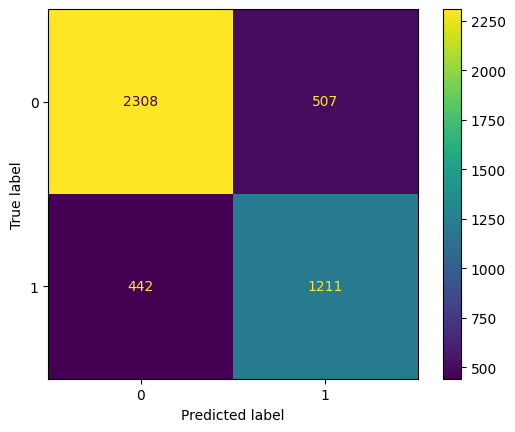

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [ ]:
joblib.dump(xgbc, '1year_lapse_model.joblib')

['1year_lapse_model.joblib']

## Model for scoring

In [ ]:

#new_data = x_test.copy()
#pol_names = pd.DataFrame({'index':data_s.index,'policy_name':data_s['policy_name']})
#new_data['index']=new_data.index
#new_data = pd.merge(new_data,pol_names,on='index',how='left')
#new_data.drop(columns=['index'],inplace=True)
model_file='1year_lapse_model.joblib'
y1_model = joblib.load(model_file)
score_data = new_data.loc[:, list(y1_model.feature_names_in_)].copy()
y1_prediction = y1_model.predict(score_data)
y1_prob = y1_model.predict_proba(score_data)


# Lapse 
XGBoost classifier model

## Training

In [ ]:
target='lapse_flag'
print('target ratios: ',data[target].sum()*100/data[target].count())


#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols)




target ratios:  43.58434813753582


In [ ]:
# Create a mask for the rows where inflation is not 3
inflation_mask_not_3 = X_train['inflation'] != 3

# Apply the mask to the training and SMOTE sets
X_train = X_train[inflation_mask_not_3]
Y_train = Y_train[inflation_mask_not_3]

inflation_mask_not_3_test = x_test['inflation'] != 3

x_test = x_test[inflation_mask_not_3_test]
y_test = y_test[inflation_mask_not_3_test]

smote_inflation_mask_not_3 = X_smote['inflation'] != 3

X_smote = X_smote[smote_inflation_mask_not_3]
Y_smote = Y_smote[smote_inflation_mask_not_3]

In [ ]:
X_train_n=X_train.copy()
Y_train_n=Y_train.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)


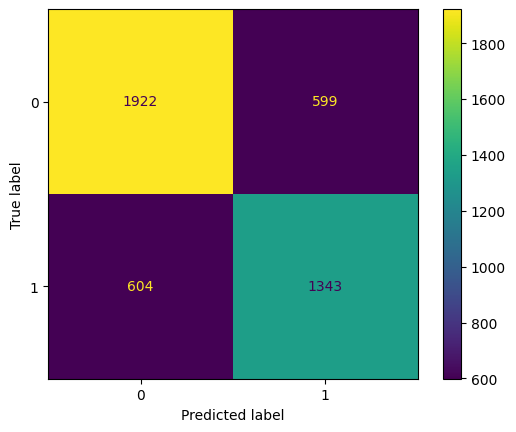

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [ ]:
joblib.dump(xgbc, 'lapse_model.joblib')

['lapse_model.joblib']

## Model for scoring

In [ ]:

#new_data = x_test.copy()
#pol_names = pd.DataFrame({'index':data_s.index,'policy_name':data_s['policy_name']})
#new_data['index']=new_data.index
#new_data = pd.merge(new_data,pol_names,on='index',how='left')
#new_data.drop(columns=['index'],inplace=True)
model_file='lapse_model.joblib'
lapse_model = joblib.load(model_file)
score_data = new_data.loc[:, list(lapse_model.feature_names_in_)].copy()
lapse_prediction = lapse_model.predict(score_data)
lapse_prob = lapse_model.predict_proba(score_data)


# Anniversary lapses

XGBoost classifier model with SMOTE resampled data

## Training

In [ ]:
target='ann_lapse'
print('target ratios: ',data[target].sum()*100/data[target].count())


#split data into training and test sets
X_train,x_test, Y_train, y_test = data_prep(data_s,target,column_excl =['policy_name','lapse_flag', 
       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse'],cat_cols=categorical_cols,filter='ann_lapse')

#apply SMOTE resampling
sm = SMOTE(sampling_strategy=0.6,random_state=42)
X_smote, Y_smote = sm.fit_resample(X_train.copy(), Y_train.copy())
print('smote resampling target ratio: ',Y_smote.sum()*100/Y_smote.count())


target ratios:  15.132307073146192
smote resampling target ratio:  37.495368655057426


In [ ]:
# Create a mask for the rows where inflation is not 3
inflation_mask_not_3 = X_train['inflation'] != 3

# Apply the mask to the training and SMOTE sets
X_train = X_train[inflation_mask_not_3]
Y_train = Y_train[inflation_mask_not_3]

inflation_mask_not_3_test = x_test['inflation'] != 3

x_test = x_test[inflation_mask_not_3_test]
y_test = y_test[inflation_mask_not_3_test]

smote_inflation_mask_not_3 = X_smote['inflation'] != 3

X_smote = X_smote[smote_inflation_mask_not_3]
Y_smote = Y_smote[smote_inflation_mask_not_3]

In [ ]:
X_train_n=X_smote.copy()
Y_train_n=Y_smote.copy()

scorer=custom_scorer
#getting best params
param_dist = {'n_estimators': randint(50,300),
              'min_samples_leaf': randint(700,2000),
              'learning_rate': randint(0,3),
              'max_depth': randint(3,5)}

# Create a XG-Boost classifier
xgb = GradientBoostingClassifier()

# Use random search to find the best hyperparameters
b=1
fbeta_scorer = make_scorer(fbeta_score, beta=b)
rand_search = RandomizedSearchCV(xgb, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5,
                                 scoring=scorer,random_state=42)

# Fit the random search object to the data
rand_search.fit(X_train_n, Y_train_n)

n_estimators=rand_search.best_params_['n_estimators']
learning_rate = rand_search.best_params_['learning_rate']
max_depth = rand_search.best_params_['max_depth']
min_samples_leaf=rand_search.best_params_['min_samples_leaf']
 #{'learning_rate': 1, 'max_depth': 4, 'min_samples_leaf': 1385, 'n_estimators': 241} 0.6381045715849234 for b=2 and recall

xgbc = GradientBoostingClassifier(n_estimators = n_estimators,learning_rate=learning_rate,max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)

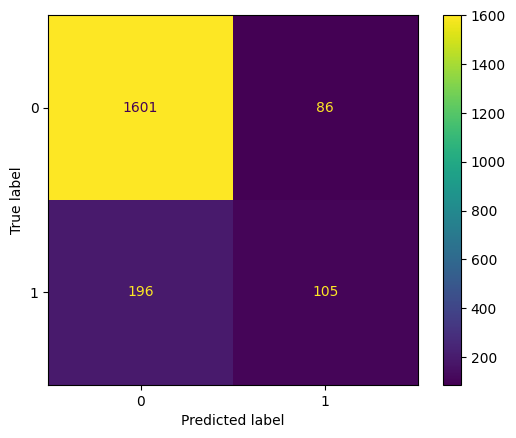

In [ ]:
xgbc.fit(X_train_n.copy(),Y_train_n.copy())
y_pred = xgbc.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix).plot()

In [ ]:
joblib.dump(xgbc, 'ann_lapse_model.joblib')

['ann_lapse_model.joblib']

## Model for scoring

In [ ]:
#new_data = x_test.copy()
#pol_names = pd.DataFrame({'index':data_s.index,'policy_name':data_s['policy_name']})
#new_data['index']=new_data.index
#new_data = pd.merge(new_data,pol_names,on='index',how='left')
#new_data.drop(columns=['index'],inplace=True)
model_file='ann_lapse_model.joblib'
ann_lapse_model = joblib.load(model_file)
score_data = new_data.loc[:, list(ann_lapse_model.feature_names_in_)].copy()
ann_prediction = ann_lapse_model.predict(score_data)
ann_prob = ann_lapse_model.predict_proba(score_data)


# Adding results to data

In [ ]:
new_data['pred 3m lapse']=m3_prediction
new_data['prob 3m lapse']=m3_prob[:,1]
new_data['pred 6m lapse']=m6_prediction
new_data['prob 6m lapse']=m6_prob[:,1]
new_data['pred y1 lapse']=y1_prediction
new_data['prob y1 lapse']=y1_prob[:,1]
new_data['pred lapse']=lapse_prediction
new_data['prob lapse']=lapse_prob[:,1]
new_data['pred ann lapse']=ann_prediction
new_data['prob ann lapse']=ann_prob[:,1]
new_data.to_csv(path+'scored_data_no_2025.csv')

In [61]:
new_data

,optionality_1.0,unemployment rate,smoker_status_N,res_code_claims_sum,sold_socio_economic_class_3.0,sold_socio_economic_class_4.0,benefits_count,smoker_status_E,funeral_count,education_Matric + 3 year Diploma,...,pred 3m lapse,prob 3m lapse,pred 6m lapse,prob 6m lapse,pred y1 lapse,prob y1 lapse,pred lapse,prob lapse,pred ann lapse,prob ann lapse
0,1,1.468841,1,-0.009279,1,0,0.837957,0,0.850484,0,...,0,0.157773,0,0.201441,0,0.101896,0,0.117594,0,0.093204
1,0,0.005862,1,-0.009279,0,0,0.837957,0,0.850484,0,...,0,0.440735,1,0.505217,1,0.514197,1,0.619341,0,0.014017
2,1,-0.725627,1,-0.009279,1,0,0.837957,0,0.850484,0,...,0,0.002637,0,0.001304,0,0.015962,0,0.026028,0,0.004780
3,0,0.005862,1,-0.009279,0,0,0.837957,0,0.850484,0,...,0,0.004611,0,0.003160,0,0.025188,0,0.017393,0,0.008751
4,0,0.005862,1,-0.009279,0,0,-0.685328,0,-0.677050,0,...,0,0.000527,0,0.006175,0,0.013372,0,0.033409,0,0.013275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463,0,1.468841,1,-0.009279,0,0,-0.177567,0,-0.167872,0,...,0,0.149818,0,0.140688,0,0.190141,0,0.392456,0,0.017700
4464,1,-0.725627,1,-0.009279,0,0,0.837957,0,0.850484,0,...,0,0.129527,0,0.044129,0,0.069197,0,0.025876,0,0.001315
4465,0,-0.725627,1,-0.009279,0,0,-0.685328,0,-0.677050,0,...,0,0.275438,0,0.454448,1,0.986161,1,0.996414,1,0.996503
4466,1,2.931819,1,-0.009279,0,0,-0.685328,0,-0.677050,0,...,0,0.004469,0,0.004965,0,0.007900,0,0.041449,0,0.001111


# Viewing scored data

## Data

In [161]:
path="C:/Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/Lapse Rate Projections/Data/AtInception/"
scored_data=pd.DataFrame(pd.read_csv(path+"scored_data_2.csv"))
orginal_data =pd.DataFrame(pd.read_csv(path+"inception_data_eco_v3.csv"))

In [162]:
old_data =pd.DataFrame(pd.read_csv(path+"inception_data.csv"))
old_data.columns

Index(['Unnamed: 0', 'policy_id', 'policy_name', 'age', 'education', 'gender',
       'income', 'smoker_status', 'sold_socio_economic_class',
       'occupation_class', 'occupation', 'orginal individual_income',
       'lead_provider_name', 'lead_type', 'sales_channel', 'sale_date',
       'campaign_name', 'underwriting_outcome', 'optionality',
       'hiv_test_required', 'eml', 'pml', 'hiv_group', 'securitygroup_id',
       'policy_type', 'benefits_count', 'last_benefit_amount',
       'cover_amount_full', 'total_funeral_premium', 'funeral_count',
       'original_premium', 'duration_policy_start_delay', '# calls',
       '# calls contacted', 'res_code_QA_sum', 'res_code_claims_sum',
       'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'policy_status', 'current_policy_status',
       'cancellation_effective_date', 'cancellation_reason', 'lapse_type',
       'lapse_flag', 'cover_

In [163]:
data=scored_data[['policy_name','pred 3m lapse',
       'prob 3m lapse', 'pred 6m lapse', 'prob 6m lapse', 'pred y1 lapse',
       'prob y1 lapse', 'pred lapse', 'prob lapse', 'pred ann lapse',
       'prob ann lapse']].merge(orginal_data,how='inner',on='policy_name')
data=data.merge(old_data[['policy_name','sale_date']],how='left',on='policy_name')

In [164]:
data['lead_provider_groups']= data['lead_provider_name'].apply(lead_prov_grouping)

In [165]:
data['sale_month'] = pd.to_datetime(data['sale_date']).dt.month

In [166]:
data['sale date'] = pd.to_datetime(data['sale_date']).dt.to_period('M')

In [167]:
data.head()

,policy_name,pred 3m lapse,prob 3m lapse,pred 6m lapse,prob 6m lapse,pred y1 lapse,prob y1 lapse,pred lapse,prob lapse,pred ann lapse,...,age_band,income_band,last_benefit_amount_band,cover_amount_full_band,total_funeral_premium_band,original_premium_band,sale_date,lead_provider_groups,sale_month,sale date
0,SD25-0416373,0,0.157773,0,0.201441,0,0.101896,0,0.117594,0,...,< 32.50,9370.00 - 16194.50,< 110120.46,< 100030.60,8.27 - 75.47,280.76 - 385.28,2025-07-19,Other,7,2025-07
1,ML24-0293644,0,0.440735,1,0.505217,1,0.514197,1,0.619341,0,...,> 50.50,> 37462.50,498472.00 - 1003478.84,200015.62 - 477116.67,> 163.69,> 596.20,2024-11-14,Phone leads,11,2024-11
2,ML23-0023842,0,0.002637,0,0.001304,0,0.015962,0,0.026028,0,...,< 32.50,9370.00 - 16194.50,110120.46 - 498472.00,< 100030.60,> 163.69,280.76 - 385.28,2023-03-07,BLDS,3,2023-03
3,ML24-0214091,0,0.004611,0,0.003160,0,0.025188,0,0.017393,0,...,32.50 - 38.50,9370.00 - 16194.50,1003478.84 - 1666875.00,200015.62 - 477116.67,> 163.69,385.28 - 596.20,2024-05-22,Web,5,2024-05
4,ML24-0140216,0,0.000527,0,0.006175,0,0.013372,0,0.033409,0,...,> 50.50,26846.00 - 37462.50,498472.00 - 1003478.84,477116.67 - 1005833.34,< 8.27,385.28 - 596.20,2024-01-10,Web,1,2024-01


In [168]:
data.columns

Index(['policy_name', 'pred 3m lapse', 'prob 3m lapse', 'pred 6m lapse',
       'prob 6m lapse', 'pred y1 lapse', 'prob y1 lapse', 'pred lapse',
       'prob lapse', 'pred ann lapse', 'prob ann lapse', 'Unnamed: 0', 'age',
       'education', 'gender', 'income', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'occupation',
       'lead_provider_name', 'lead_type', 'sales_channel', 'campaign_name',
       'underwriting_outcome', 'optionality', 'hiv_test_required', 'eml',
       'pml', 'hiv_group', 'securitygroup_id', 'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'lapse_flag', 'inflation', 'unemployment r

In [169]:
for t in [ 'prob 3m lapse', 
       'prob 6m lapse', 'prob y1 lapse',
       'prob lapse','prob ann lapse']:
    ceilings = [0.0, 0.1,0.2,0.3001,0.4,0.5,0.6,0.7,0.8,0.9,1.05]
    bins=[f'{math.floor((n-0.1)*10)/10} - {math.floor(n*10)/10}' for n in ceilings[1:]]

    data[t+' band'] = pd.cut(data[t],bins=ceilings, labels=bins,right=False)


In [170]:
data

,policy_name,pred 3m lapse,prob 3m lapse,pred 6m lapse,prob 6m lapse,pred y1 lapse,prob y1 lapse,pred lapse,prob lapse,pred ann lapse,...,original_premium_band,sale_date,lead_provider_groups,sale_month,sale date,prob 3m lapse band,prob 6m lapse band,prob y1 lapse band,prob lapse band,prob ann lapse band
0,SD25-0416373,0,0.157773,0,0.201441,0,0.101896,0,0.117594,0,...,280.76 - 385.28,2025-07-19,Other,7,2025-07,0.1 - 0.2,0.2 - 0.3,0.1 - 0.2,0.1 - 0.2,0.0 - 0.1
1,ML24-0293644,0,0.440735,1,0.505217,1,0.514197,1,0.619341,0,...,> 596.20,2024-11-14,Phone leads,11,2024-11,0.4 - 0.5,0.5 - 0.6,0.5 - 0.6,0.6 - 0.7,0.0 - 0.1
2,ML23-0023842,0,0.002637,0,0.001304,0,0.015962,0,0.026028,0,...,280.76 - 385.28,2023-03-07,BLDS,3,2023-03,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1
3,ML24-0214091,0,0.004611,0,0.003160,0,0.025188,0,0.017393,0,...,385.28 - 596.20,2024-05-22,Web,5,2024-05,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1
4,ML24-0140216,0,0.000527,0,0.006175,0,0.013372,0,0.033409,0,...,385.28 - 596.20,2024-01-10,Web,1,2024-01,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4463,SD25-0412432,0,0.149818,0,0.140688,0,0.190141,0,0.392456,0,...,385.28 - 596.20,2025-07-09,Web,7,2025-07,0.1 - 0.2,0.1 - 0.2,0.1 - 0.2,0.3 - 0.4,0.0 - 0.1
4464,ML23-0037470,0,0.129527,0,0.044129,0,0.069197,0,0.025876,0,...,280.76 - 385.28,2023-05-08,Other,5,2023-05,0.1 - 0.2,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1
4465,ML23-0033775,0,0.275438,0,0.454448,1,0.986161,1,0.996414,1,...,385.28 - 596.20,2023-04-28,Web,4,2023-04,0.2 - 0.3,0.4 - 0.5,0.9 - 1.0,0.9 - 1.0,0.9 - 1.0
4466,ML22-0004385,0,0.004469,0,0.004965,0,0.007900,0,0.041449,0,...,280.76 - 385.28,2022-11-21,Web,11,2022-11,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1,0.0 - 0.1


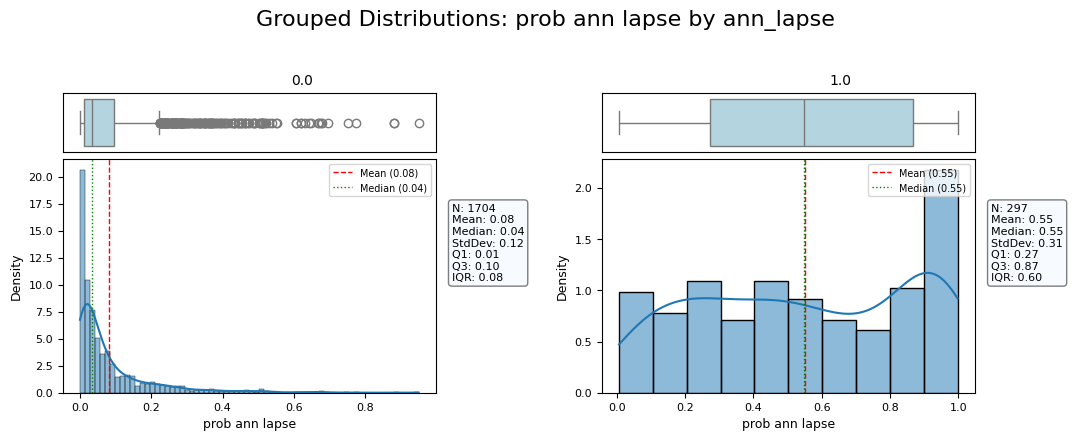

In [171]:
#['policy_name', 'pred 3m lapse', 'prob 3m lapse', 'pred 6m lapse',
#       'prob 6m lapse', 'pred y1 lapse', 'prob y1 lapse', 'pred lapse',
#       'prob lapse', 'pred ann lapse', 'prob ann lapse', 'age', 'income', 'eml',
#       'pml','benefits_count',
#       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
#       'funeral_count', 'original_premium', 'duration_policy_start_delay',
#       '# calls', '# calls contacted', 'res_code_QA_sum',
#       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
#       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
#       'res_code_update_sum', 'lapse_flag', 'inflation', 'unemployment rate',
#       '3month_lapse', '6month_lapse', '1yr_lapse', 'ann_lapse', ]

value_col=  'prob ann lapse'
plot_grouped_distributions(data, value_col, category_col='ann_lapse',cat_list = [], main_title="Grouped Distributions")

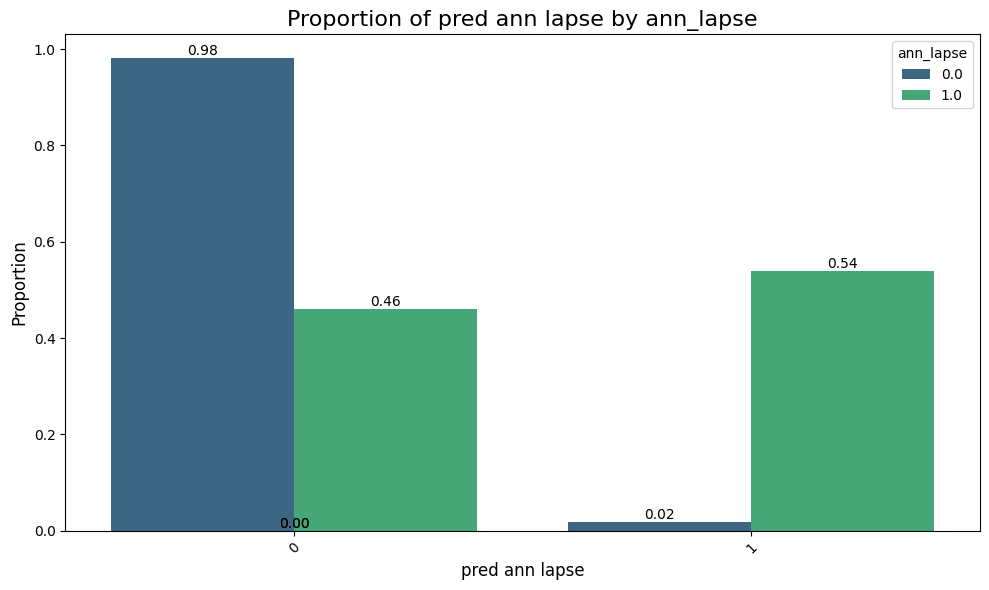

In [172]:
cat= 'pred ann lapse'
split= 'ann_lapse' #'pred 3m lapse' #'3month_lapse'
bar_comp(data,category=cat,split=split)

## Band view

In [163]:
target='3month_lapse'
df = DataPreparation(df=data.copy())
df.aggregation(groupby_cols=['prob 3m lapse band'],cat_cols=[],agg_dict_not_cat_cols={target: pd.NamedAgg(column=target, aggfunc='sum'),'total policies': pd.NamedAgg(column=target, aggfunc='count')})
df.agg_df['lapse rate'] = df.agg_df[target]/df.agg_df['total policies']
df.agg_df

C:\Users/E1005279/OneDrive - Sanlam Life Insurance Limited/MWL/MWLrepo/MiWayLife2/Data_Analysis_Package\data_preparation.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(groupby_cols).agg(**agg_dict).reset_index()


,prob 3m lapse band,3month_lapse,total policies,lapse rate
0,0.0 - 0.1,77,2396,0.032137
1,0.1 - 0.2,131,524,0.250000
2,0.2 - 0.3,101,330,0.306061
3,0.3 - 0.4,119,303,0.392739
4,0.4 - 0.5,103,226,0.455752
5,0.5 - 0.6,112,227,0.493392
6,0.6 - 0.7,79,162,0.487654
7,0.7 - 0.8,94,166,0.566265
8,0.8 - 0.9,57,106,0.537736
9,0.9 - 1.0,15,28,0.535714


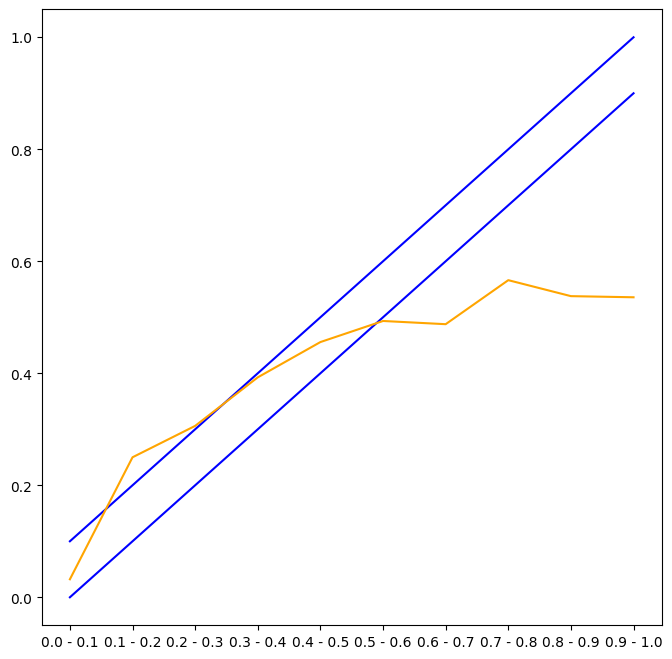

In [164]:
plt.figure(figsize=(8, 8))
plt.plot(bins,[0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],color='blue')
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],color='blue')
plt.plot(df.agg_df['lapse rate'],color='orange')

plt.show()

## U-graphs

C:\Users\E1005279\AppData\Local\Temp\ipykernel_26036\4255608215.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df= data[['policy_name',band1,band2]].groupby([band1,band2]).count().unstack()


<Axes: xlabel='prob ann lapse band'>

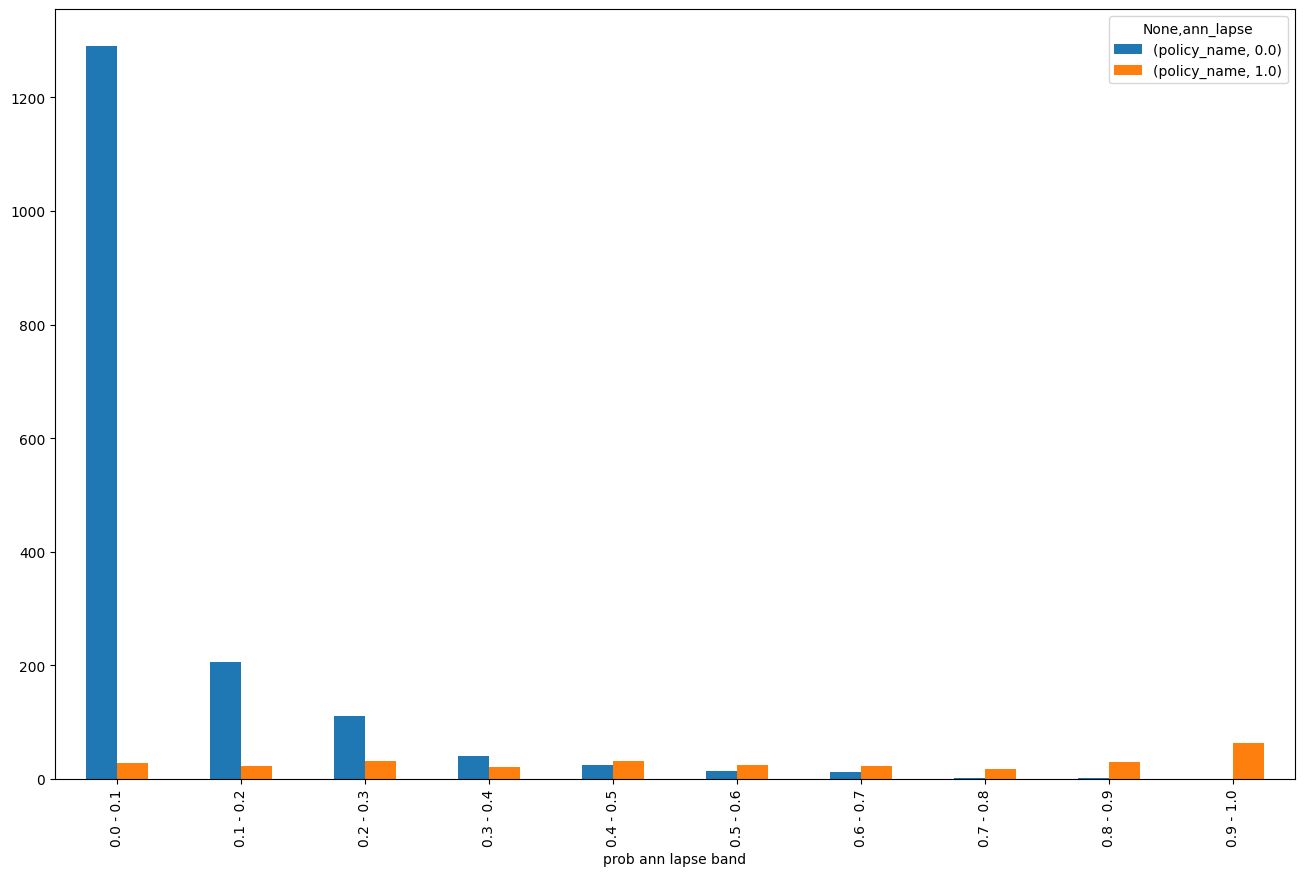

In [213]:
band1='prob ann lapse band'
band2='ann_lapse'

new_df= data[['policy_name',band1,band2]].groupby([band1,band2]).count().unstack() 
new_df.plot(kind='bar',figsize=(16,10))

In [187]:
new_df.columns

Index(['policy_name'], dtype='object')

## probability band cohort

In [219]:
def stats_nums(data):
    mean_val = data.mean()
    median_val = data.median()
    std_dev = data.std()
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    count = len(data)
    return [mean_val,median_val,std_dev,q1,q3,iqr]

[]

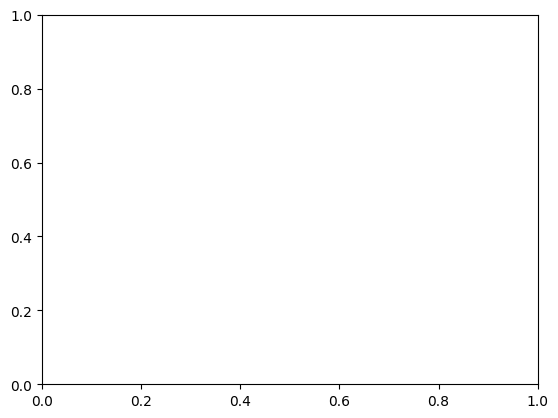

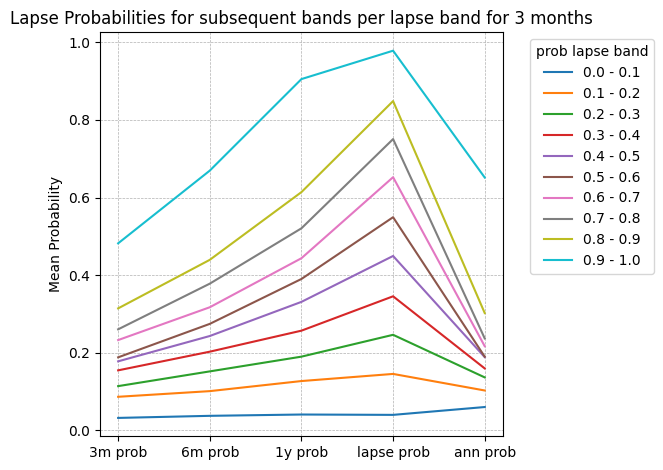

In [ ]:
#['0.1 - 0.2', '0.4 - 0.5', '0.0 - 0.1', '0.9 - 1.0', '0.6 - 0.7', '0.2 - 0.3', '0.3 - 0.4', '0.5 - 0.6', '0.8 - 0.9', '0.7 - 0.8']
band_name = 'prob lapse band'
bands=['0.0 - 0.1','0.1 - 0.2', '0.2 - 0.3', '0.3 - 0.4','0.4 - 0.5', '0.5 - 0.6', '0.6 - 0.7',  '0.7 - 0.8', '0.8 - 0.9','0.9 - 1.0']
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 10))))
fig, ax = plt.subplots()

for i in range(len(bands)):
    df_pbc = data[data[band_name]== bands[i]].copy()
    stats = {}
    y=[]
    lower=[]
    upper=[]

    stats['3m prob'] = stats_nums(df_pbc['prob 3m lapse'])
    y.append(stats['3m prob'][0])
    lower.append(stats['3m prob'][0]-stats['3m prob'][2])
    upper.append(stats['3m prob'][0]+stats['3m prob'][2])

    stats['6m prob'] = stats_nums(df_pbc['prob 6m lapse'])
    y.append(stats['6m prob'][0])
    lower.append(stats['6m prob'][0]-stats['6m prob'][2])
    upper.append(stats['6m prob'][0]+stats['6m prob'][2])

    stats['1y prob'] = stats_nums(df_pbc['prob y1 lapse'])
    y.append(stats['1y prob'][0])
    lower.append(stats['1y prob'][0]-stats['1y prob'][2])
    upper.append(stats['1y prob'][0]+stats['1y prob'][2])



    stats['lapse prob'] = stats_nums(df_pbc['prob lapse'])
    y.append(stats['lapse prob'][0])
    lower.append(stats['lapse prob'][0]-stats['lapse prob'][2])
    upper.append(stats['lapse prob'][0]+stats['lapse prob'][2])

    stats['ann prob'] = stats_nums(df_pbc['prob ann lapse'])
    y.append(stats['ann prob'][0])
    lower.append(stats['ann prob'][0]-stats['ann prob'][2])
    upper.append(stats['ann prob'][0]+stats['ann prob'][2])

 
    ax.plot(stats.keys(),y, label=bands[i])
    #ax.fill_between(stats.keys(), lower, upper, alpha=.1)

ax.set_title('Lapse Probabilities for subsequent bands per lapse band for 3 months')
ax.set_ylabel('Mean Probability')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title=band_name, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.plot()


## Sale cohort view

In [23]:
data.columns



Index(['policy_name', 'pred 3m lapse', 'prob 3m lapse', 'pred 6m lapse',
       'prob 6m lapse', 'pred y1 lapse', 'prob y1 lapse', 'pred lapse',
       'prob lapse', 'pred ann lapse', 'prob ann lapse', 'Unnamed: 0', 'age',
       'education', 'gender', 'income', 'smoker_status',
       'sold_socio_economic_class', 'occupation_class', 'occupation',
       'lead_provider_name', 'lead_type', 'sales_channel', 'campaign_name',
       'underwriting_outcome', 'optionality', 'hiv_test_required', 'eml',
       'pml', 'hiv_group', 'securitygroup_id', 'benefits_count',
       'last_benefit_amount', 'cover_amount_full', 'total_funeral_premium',
       'funeral_count', 'original_premium', 'duration_policy_start_delay',
       '# calls', '# calls contacted', 'res_code_QA_sum',
       'res_code_claims_sum', 'res_code_no interest_sum', 'res_code_other_sum',
       'res_code_payment_sum', 'res_code_quote_sum', 'res_code_sale_sum',
       'res_code_update_sum', 'lapse_flag', 'inflation', 'unemployment r

(88, 70)
(77, 70)
(65, 70)
(71, 70)
(94, 70)
(97, 70)
(48, 70)


[]

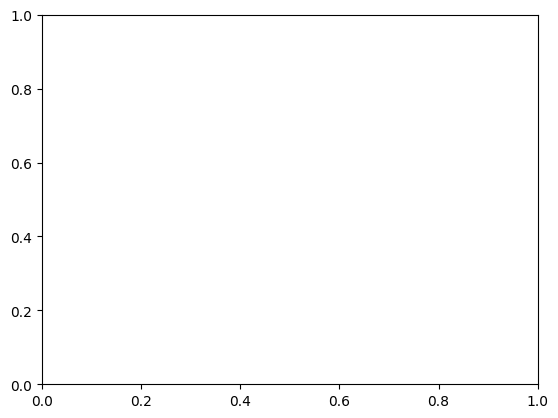

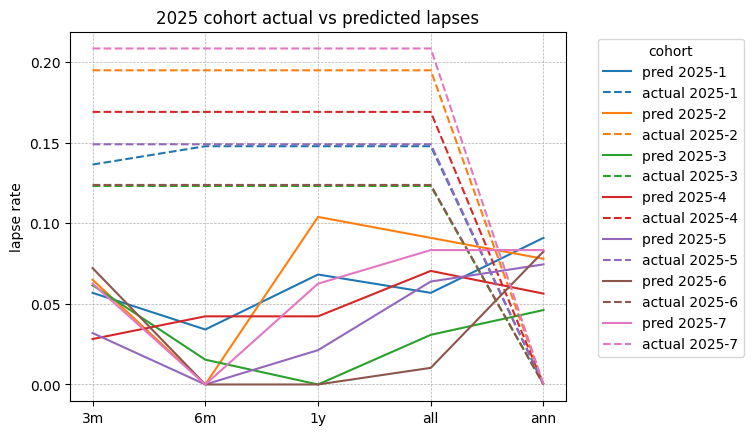

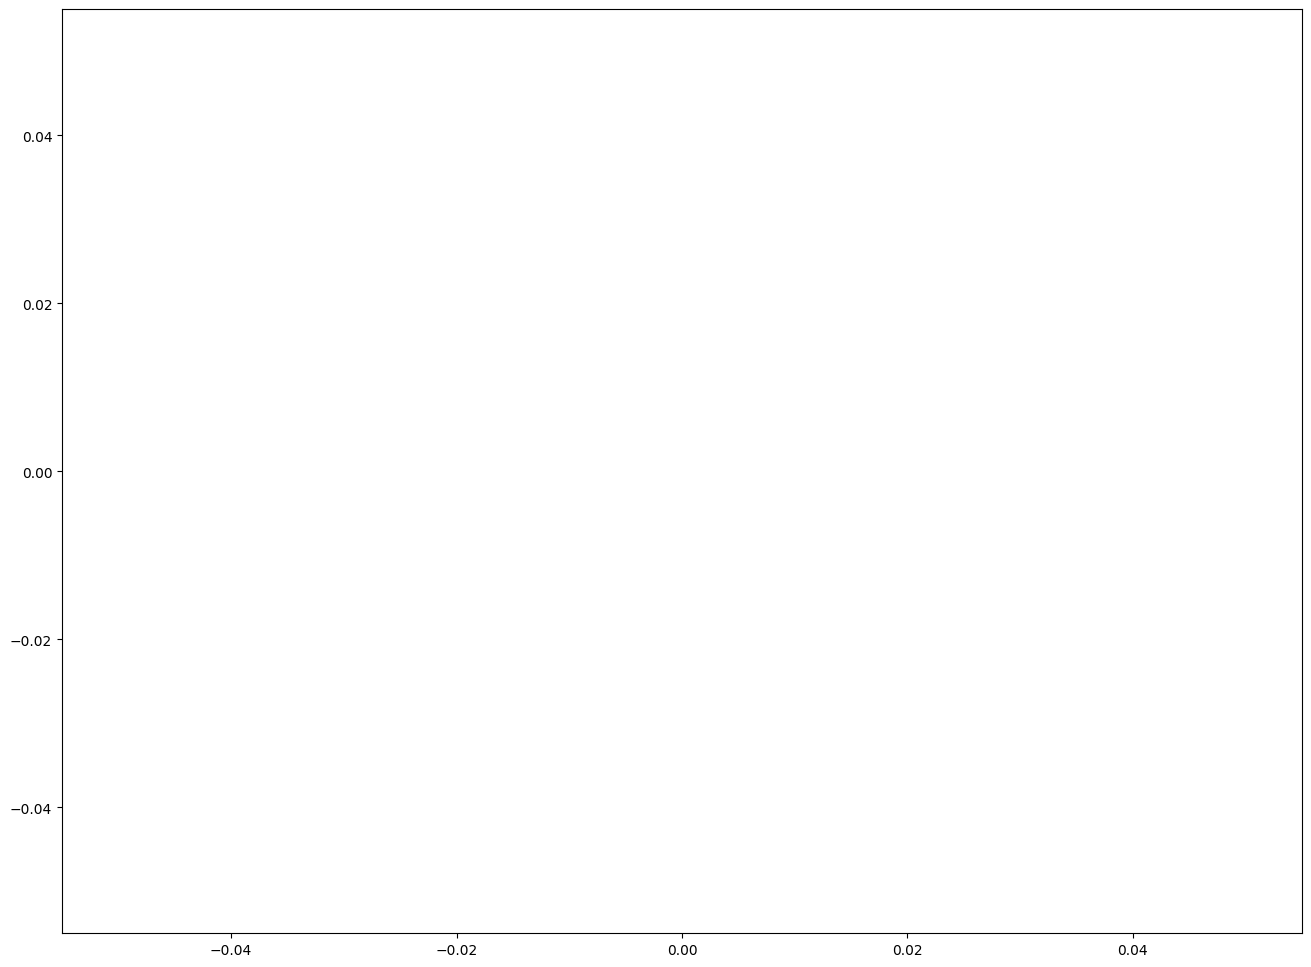

In [173]:
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 10))))
fig, ax = plt.subplots()


for year in [2025]:
#    if year==2023:
#        col='b'
#    else:
#        col='c'
    for month in range(1,8):
        policies=data[(pd.to_datetime(data['sale_date']).dt.year==year) & (pd.to_datetime(data['sale_date']).dt.month==month)]['policy_name']
        cohort=data[data['policy_name'].isin(policies)]
        print(cohort.shape)
        x=['3m','6m','1y','all','ann']
        y_pred=[]
        y_pred.append(cohort['pred 3m lapse'].sum()/len(policies))
        y_pred.append(cohort['pred 6m lapse'].sum()/len(policies))
        y_pred.append(cohort['pred y1 lapse'].sum()/len(policies))
        y_pred.append(cohort['pred lapse'].sum()/len(policies))
        y_pred.append(cohort['pred ann lapse'].sum()/len(policies))
        y_act = []
        y_act.append(cohort['3month_lapse'].sum()/len(policies))
        y_act.append(cohort['6month_lapse'].sum()/len(policies))
        y_act.append(cohort['1yr_lapse'].sum()/len(policies))
        y_act.append(cohort['lapse_flag'].sum()/len(policies))
        y_act.append(cohort['ann_lapse'].sum()/len(policies))

        line1, = ax.plot(x,y_pred, label=f'pred {year}-{month}')#, color=col)
        #ax.plot(x,y_act, label=f'actual {year}-{month}', linestyle='dashed', color=col)
        ax.plot(x,y_act, label=f'actual {year}-{month}', linestyle='dashed', color=line1.get_color())

plt.figure(figsize=(16, 12)) 
ax.set_title('2025 cohort actual vs predicted lapses') #vs predicted
ax.set_ylabel('lapse rate')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title='cohort', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.plot()